## Implementing Q-Learning in Keras

In [1]:
import os 
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0' 
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' 

In [2]:
import sys 
sys.setrecursionlimit(1500) 

import gym 
import numpy as np 

# Create the environment 
env = gym.make('CartPole-v1') 

# Set random seed for reproducibility 
np.random.seed(42) 
env.action_space.seed(42) 
env.observation_space.seed(42)

[42]

In [3]:
# Suppress warnings for a cleaner notebook or console experience
import warnings
warnings.filterwarnings('ignore')

# Override the default warning function
def warn(*args, **kwargs):
    pass
warnings.warn = warn

# Import necessary libraries for the Q-Learning model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input  # Import Input layer
from tensorflow.keras.optimizers import Adam
import gym  # Ensure the environment library is available

# Define the model building function
def build_model(state_size, action_size): 
    model = Sequential() 
    model.add(Input(shape=(state_size,)))  # Use Input layer to specify the input shape 
    model.add(Dense(24, activation='relu')) 
    model.add(Dense(24, activation='relu')) 
    model.add(Dense(action_size, activation='linear')) 
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001)) 
    return model 

# Create the environment and set up the model
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0] 
action_size = env.action_space.n 
model = build_model(state_size, action_size)

In [4]:
import random
import numpy as np
from collections import deque
import tensorflow as tf

# Define epsilon and epsilon_decay
epsilon = 1.0  # Starting with a high exploration rate
epsilon_min = 0.01  # Minimum exploration rate
epsilon_decay = 0.99  # Faster decay rate for epsilon after each episode

# Replay memory
memory = deque(maxlen=2000)

def remember(state, action, reward, next_state, done):
    """Store experience in memory."""
    memory.append((state, action, reward, next_state, done))

def replay(batch_size=64):  # Increased batch size
    """Train the model using a random sample of experiences from memory."""
    if len(memory) < batch_size:
        return  # Skip replay if there's not enough experience

    minibatch = random.sample(memory, batch_size)  # Sample a random batch from memory
    
    # Extract information for batch processing
    states = np.vstack([x[0] for x in minibatch])
    actions = np.array([x[1] for x in minibatch])
    rewards = np.array([x[2] for x in minibatch])
    next_states = np.vstack([x[3] for x in minibatch])
    dones = np.array([x[4] for x in minibatch])
    
    # Predict Q-values for the next states in batch
    q_next = model.predict(next_states)
    # Predict Q-values for the current states in batch
    q_target = model.predict(states)
    
    # Vectorized update of target values
    for i in range(batch_size):
        target = rewards[i]
        if not dones[i]:
            target += 0.95 * np.amax(q_next[i])  # Update Q value with the discounted future reward
        q_target[i][actions[i]] = target  # Update only the taken action's Q value
    
    # Train the model with the updated targets in batch
    model.fit(states, q_target, epochs=1, verbose=0)  # Train in batch mode

    # Reduce exploration rate (epsilon) after each training step
    global epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

def act(state):
    """Choose an action based on the current state and exploration rate."""
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)  # Explore: choose a random action
    act_values = model.predict(state)  # Exploit: predict action based on the state
    return np.argmax(act_values[0])  # Return the action with the highest Q-value

# Define the number of episodes you want to train the model for
episodes = 10  # You can set this to any number you prefer
train_frequency = 5  # Train the model every 5 steps

for e in range(episodes):
    state, _ = env.reset()  # Unpack the tuple returned by env.reset()
    state = np.reshape(state, [1, state_size])
    for time in range(200):  # Limit to 200 time steps per episode
        action = act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        reward = reward if not done else -10
        next_state = np.reshape(next_state, [1, state_size])
        remember(state, action, reward, next_state, done)  # Store experience
        state = next_state
        
        if done:
            print(f"episode: {e+1}/{episodes}, score: {time}, e: {epsilon:.2}")
            break
        
        # Train the model every 'train_frequency' steps
        if time % train_frequency == 0:
            replay(batch_size=64)  # Call replay with larger batch size for efficiency

env.close()


episode: 1/10, score: 11, e: 1.0
episode: 2/10, score: 32, e: 1.0
episode: 3/10, score: 18, e: 1.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
episode: 4/10, score: 9, e: 0.98
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
episode: 5/10, score: 23, e: 0.93
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/ste

### Evaluate the performance

In [5]:
for e in range(10):  

    state, _ = env.reset()  # Unpack the state from the tuple 
    state = np.reshape(state, [1, state_size])  # Reshape the state correctly 
    for time in range(500):  
        env.render()  
        action = np.argmax(model.predict(state)[0])  
        next_state, reward, terminated, truncated, _ = env.step(action)  # Unpack the five return values 
        done = terminated or truncated  # Check if the episode is done 
        next_state = np.reshape(next_state, [1, state_size])  
        state = next_state  
        if done:  
            print(f"episode: {e+1}/10, score: {time}")  
            break  

env.close() 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
episode: 1/10, score: 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
episode: 2/10, score: 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/

In [6]:
scores = []

for e in range(10):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    score = 0  # 에피소드 점수 초기화

    for time in range(500):
        env.render()
        action = np.argmax(model.predict(state)[0])
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state = np.reshape(next_state, [1, state_size])
        state = next_state
        score += 1  # 점수 증가

        if done:
            print(f"episode: {e+1}/10, score: {score}")
            break

    scores.append(score)  # 에피소드 끝날 때 점수 저장

env.close()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
episode: 1/10, score: 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
episode: 2/10, score: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1

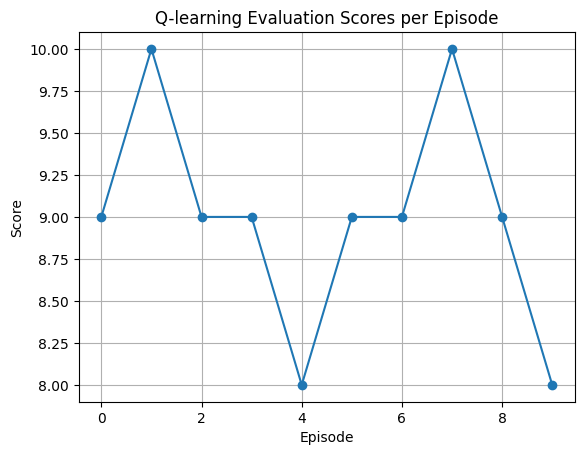

In [8]:
import matplotlib.pyplot as plt

plt.plot(scores, marker='o')
plt.title('Q-learning Evaluation Scores per Episode')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.grid(True)
plt.show()
